1 Load Preprocessed Data

In [23]:
from pathlib import Path

# base directory from where the notebook was launched
base_dir = Path.cwd()

# load data
file_path = base_dir.parent / "01_preprocessing" / "data" / "titanic.csv"

display(base_dir)
display(file_path)

PosixPath('/Users/AnanyaPal1/Documents/data-engineering/notebooks/titanic/02_linear_regression')

PosixPath('/Users/AnanyaPal1/Documents/data-engineering/notebooks/titanic/01_preprocessing/data/titanic.csv')

In [24]:
import pandas as pd

df = pd.read_csv(file_path)
print(df.shape)

(891, 14)


In [25]:
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive',
       'alone'],
      dtype='object')

In [26]:
df["survived"].value_counts()
df["class"].value_counts()

class
Third     491
First     216
Second    184
Name: count, dtype: int64

2 Implement Linear Regression

Goal: predict whether the fare of a traveller's ticket based on the class they were travelling

expected: ticket fare might be lower for children as compared to adults

- Regressor (independent variables/ predictors/features) : fare
- Regressand (dependent variable / response/target) : age

In [29]:
import sklearn
from sklearn.linear_model import LinearRegression

In [34]:
feature_name = "fare"
target_name = "age"

data, target = df[[feature_name]], df[target_name]

In [35]:
linear_regression = LinearRegression()
linear_regression.fit(data,target)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [36]:
weight_fare = linear_regression.coef_[0]
weight_fare

np.float64(0.03284846289897327)

In [38]:
intercept_age = linear_regression.intercept_
intercept_age

np.float64(28.054565511777696)

In [43]:
import numpy as np
fare_range = np.linspace(data.min(), data.max(), num=100)

predicted_age = (
    weight_fare * fare_range + intercept_age
)

3 Plot fitted model

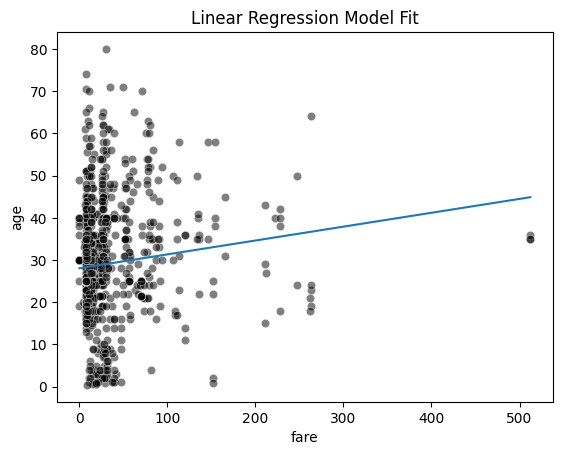

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=data[feature_name], y=target, color="black", alpha=0.5)
plt.plot(fare_range, predicted_age)
_ = plt.title("Linear Regression Model Fit")


Intepretation:

- Slight positive but very weak correlation between fare and age.
- Fare alone is not a good indicator of a traveller's age. 

4 Implement Linear Regression using another set of predictors

Goal: predict whether the fare of a traveller's ticket based on the class they were travelling

expected: ticket fare might be lower for children as compared to adults

- Regressor (independent variables/ predictors/features) : ticket class 
- Regressand (dependent variable / response/target) : fare

4-1 One-hot encoding "class" feature

In [46]:
display(df.columns)

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive',
       'alone'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_array = encoder.fit_transform(df[['pclass']])

encoded_df = pd.DataFrame(encoded_array, 
                          columns=encoder.get_feature_names_out(['pclass']))

df_encoded = pd.concat(
    [df,encoded_df],
    axis=1
)

print(df_encoded.head())


   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male  embark_town alive  alone  pclass_2  pclass_3  
0    man        True  Southampton    no  False       0.0       1.0  
1  woman       False    Cherbourg   yes  False       0.0       0.0  
2  woman       False  Southampton   yes   True       0.0       1.0  
3  woman       False  Southampton   yes  False       0.0       0.0  
4    man        True  Southampton    no   True       0.0       1.0  


4-1.2 Save one-hot encoded df

In [62]:
from pathlib import Path

file_path = Path.cwd().parent / "01_preprocessing" / "data" / "one_hot_encoded_titanic.csv"

if not file_path.parent.exists():
    file_path.parent.mkdir(parents=True, exist_ok=True)

print(file_path)

/Users/AnanyaPal1/Documents/data-engineering/notebooks/titanic/01_preprocessing/data/one_hot_encoded_titanic.csv


In [63]:
save_encoded_df = df_encoded.to_csv(file_path, index=False)

one-hot encoding - categories are mutually exclusive - one is always implied when the others ara 0 

- since we have three categories/ travel-classes, only 2 columns are required

- also avoids multicollinearity

4-2 Implement Linear Regression

In [69]:
load_df_encoded = pd.read_csv(file_path)
#display(load_df_encoded.columns)

feature_names = ["pclass_2", "pclass_3"]
target_name = "fare"

data, target = load_df_encoded[feature_names], load_df_encoded[target_name]

In [70]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(
    data, target
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [79]:
weight_travelling_class = linear_regression.coef_
weight_travelling_class

array([-63.49250435, -70.4791374 ])

In [ ]:
for name, coef in zip(feature_names, linear_regression.coef_):
    print(f"{name}: {coef:.2f}")

pclass_2: -63.49
pclass_3: -70.48


In [77]:
intercept_fare = linear_regression.intercept_
intercept_fare

np.float64(84.15468750000011)

4-3 Plot Linear Regression Model

In [89]:
predicted_fares = (
    weight_travelling_class[0] * load_df_encoded['pclass_2'] 
    + weight_travelling_class[1] * load_df_encoded['pclass_3']
    + intercept_fare
)
predicted_fares


0      13.675550
1      84.154688
2      13.675550
3      84.154688
4      13.675550
         ...    
886    20.662183
887    84.154688
888    13.675550
889    84.154688
890    13.675550
Length: 891, dtype: float64

The predictor (traveller's class) is categorical, and we do not have a continuous x-axis to draw a line through it. 

Plotting idea:
- Actual Average Fare per class from the data (group existing fares from the "Fare" column acc  to class from the "pclass" column)
- Model-Predicted Fare (one number per class from the regression)

In [87]:
actual_average = (
    load_df_encoded
    .groupby('pclass')['fare']
    .mean()
    .reset_index(name='actual fare')
    .rename(columns={"pclass":"class"})
)

In [92]:
X = load_df_encoded[["pclass_2", "pclass_3"]]

load_df_encoded["Predicted Fare"] = linear_regression.predict(X)

predicted_means = (
    load_df_encoded
    .groupby("pclass")["Predicted Fare"]
    .mean()
    .reset_index()
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(
    x = load_df_encoded[feature_names],
    y = target_name,
    color = 'black',
    alpha = 0.5
)

plt.plot(
    
)